In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [25]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [3]:
# Some code used from reference below:
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

train = pd.read_csv('../oneHotTrain.csv')
test = pd.read_csv('../oneHotTest.csv')

In [4]:
len(train)

1460

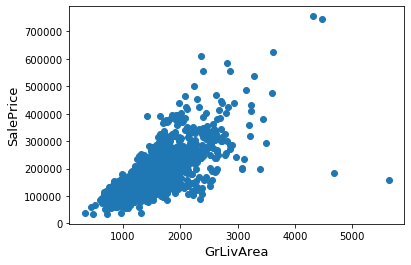

In [5]:
# from reference code
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [6]:
train.columns

Index(['ID', 'MSSubClass', 'MSZoning.C..all.', 'MSZoning.FV', 'MSZoning.RH',
       'MSZoning.RL', 'MSZoning.RM', 'LotFrontage', 'LotArea', 'Street.Grvl',
       ...
       'SaleType.New', 'SaleType.Oth', 'SaleType.WD', 'SaleCondition.Abnorml',
       'SaleCondition.AdjLand', 'SaleCondition.Alloca', 'SaleCondition.Family',
       'SaleCondition.Normal', 'SaleCondition.Partial', 'SalePrice'],
      dtype='object', length=301)

## Attempt 1: Random Forest

In [7]:
# splitting training data up to test different models

tmpY = train.SalePrice
tmpX = train.drop(columns=['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(tmpX, tmpY, test_size=0.25, random_state=0)

In [8]:
# best_score = 0
# for i in range(10,190,20):
#     for j in range(5,13,3):
#         for k in range(2,6):
#             for l in range(1,4):
#                 rf = RandomForestClassifier(n_estimators=i, 
#                                             criterion='entropy', 
#                                             max_depth=j, 
#                                             min_samples_split=k, 
#                                             min_samples_leaf=l)
#                 rf.fit(X_train, y_train)

#                 print('n_estimators=', i, ', max_depth=', j, ', min_samples_split=', k, ', min_samples_leaf=', l)
#                 score = rf.score(X_test, y_test)
#                 print(score)
#                 print()

#                 if score > best_score:
#                     best_score = score

# print('best: ', best_score)

I'm taking the four best classifiers and doing an ensemble of them for the submission

In [12]:
rf_g_0 = RandomForestClassifier(n_estimators=50, 
                            criterion='gini', 
                            max_depth=5, 
                            min_samples_split=4, 
                            min_samples_leaf=2)

rf_g_1 = RandomForestClassifier(n_estimators=170, 
                            criterion='gini', 
                            max_depth=5, 
                            min_samples_split=3, 
                            min_samples_leaf=1)

rf_e_0 = RandomForestClassifier(n_estimators=90, 
                            criterion='entropy', 
                            max_depth=5, 
                            min_samples_split=2, 
                            min_samples_leaf=2)

rf_e_1 = RandomForestClassifier(n_estimators=170, 
                            criterion='entropy', 
                            max_depth=5, 
                            min_samples_split=5, 
                            min_samples_leaf=1)

# testY = test.SalePrice
# testX = test.drop(columns=['SalePrice'])

rf_g_0.fit(tmpX, tmpY)
rf_g_1.fit(tmpX, tmpY)
rf_e_0.fit(tmpX, tmpY)
rf_e_1.fit(tmpX, tmpY)

prediction = (0.25 * rf_g_0.predict(test)) + (0.25 * rf_g_1.predict(test)) + \
             (0.25 * rf_e_0.predict(test)) + (0.25 * rf_e_1.predict(test))

In [14]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['SalePrice'] = prediction
sub.to_csv('submission.csv',index=False)

## Result: 0.27306
### Definitely room for improvement...

## Attempt 2: GradientBoostingRegressor

In [18]:
# Referenced code
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=0)

In [20]:
gboost.fit(tmpX, tmpY)
prediction = gboost.predict(test)

In [22]:
prediction

array([128753.21286104, 163308.55034786, 190049.38162399, ...,
       164295.21465023, 123215.5520683 , 221505.65346626])

In [23]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['SalePrice'] = prediction
sub.to_csv('submission.csv',index=False)

## Result: 0.12328
### That's a lot better... now at number 918

## Attempt 3: XGBoost